## Load all required packages

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np 
from sklearn import mixture
import gensim
from cleantext import clean
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics.pairwise import cosine_similarity
from dlutils import dlutils
import inspect
import string
from dlutils import dlutils

## Load data

In [2]:
import os
input_dir_raw = 'data/heise'
input_file = os.path.join(os.path.abspath(input_dir_raw), 'heise.txt')
print(input_file)
with open(input_file, 'r', encoding='utf-8') as file:
     #line for line in file:
        input_ = file.readlines()

C:\Users\Viktoria\Desktop\Github\pvtm\data\heise\heise.txt


## Define preprocess function and PVTM class

In [3]:
# from gensim.models.doc2vec import TaggedDocument, Doc2Vec
class Documents(object):
    """
    """
    
    def __init__(self, documents):
        self.documents = documents

    def __iter__(self):
        for i, doc in enumerate(self.documents):
            yield gensim.models.doc2vec.TaggedDocument(words=doc, tags=[i])
            
# x_docs = Documents(cleaned_texts)

model = gensim.models.Doc2Vec(vector_size=100,
                dbow_words=1,
                dm=0,
                epochs=1,
                window=5,
                seed=123,
                min_count=5,
                workers=6,
                alpha=0.025,
                min_alpha=0.025)

In [4]:
import inspect
class PVTM(Documents):
    def preprocess(self,texts, **kwargs):        
        '''
        The finction takes a list of texts and removes stopwords as well as very frequent and very unfrequent words.
        The function also uses clean() function from clean-text to lowercase, 
        to remove special characters, number, currency symbols etc. 
        '''
        translator=str.maketrans('','',string.punctuation)
        texts = [text.translate(translator) for text in texts]
        texts= [clean(x, **{key: value for key, value in kwargs.items() 
                                              if key in inspect.getfullargspec(clean).args}) for x in texts]
        _input, self.vocab = dlutils.popularity_based_prefiltering(texts,**{key: value for key, value in kwargs.items() 
                                              if key in inspect.getfullargspec(dlutils.popularity_based_prefiltering).args}) 
        return _input, self.vocab
    
    def __init__(self, texts, preprocess=True, **kwargs):        
        if preprocess==True:
            texts, vocab = self.preprocess(texts, **kwargs)
        x = [kk.split() for kk in texts]
        Documents.__init__(self,x)
        self.x_docs = Documents(x)
    def fit(self, n_range=10, alpha_value_steps = 0.002, **kwargs):    
        self.model = gensim.models.Doc2Vec(**{key: value for key, value in kwargs.items() 
                                              if key in inspect.getfullargspec(gensim.models.Doc2Vec).args})
        print('Building vocab')
        self.model.build_vocab(pvtm.x_docs)
        doc_counts = len(self.documents)
        for epoch in range(n_range):
            print("epoch " + str(epoch))
            pvtm.model.train(pvtm.x_docs, total_examples=doc_counts, epochs=1)
            #     model.save(MODEL_SAVE_NAME)
            pvtm.model.alpha -= alpha_value_steps
        self.gmm= mixture.GaussianMixture(**{key: value for key, value in kwargs.items() 
                                             if key in inspect.getfullargspec(mixture.GaussianMixture).args})
        print('GMM Clustering')
        self.doc_vectors=np.array(self.model.docvecs.vectors_docs)
        self.gmm.fit(self.doc_vectors)
        print('BIC: {}'.format(self.gmm.bic(self.doc_vectors)))
    
    #def gmm_clustering(self, **kwargs):
    #    """
    #    initialize GMM model
    #    """
    #    self.gmm = mixture.GaussianMixture(**kwargs)
        
        
    def cluster_center(self, vectors, gmm):
        """
        Approximates cluster centers for a given clustering from a GMM.
        First method only takes the topic with the highest probability per document into account.
        Averaging the document vectors per topic cluster provides the cluster center for the topic.
        Second method  approximates cluster centers for a given clustering 
        from a GMM with weighted single vectors from a certain topic.
        Returns two lists of the cluster centers.
        """
        self.clustercenter = []
        assignments = gmm.predict(vectors)
        n_components = np.unique(assignments).shape[0]
        for i in range(n_components):
            gmm_centerindexe = np.where(assignments==i, True, False)        
            self.clustercenter.append(vectors[gmm_centerindexe].mean(0))
        
        self.clustercenter_probas = []
        assignments_proba = gmm.predict_proba(vectors)
        n_components = assignments_proba.shape[1] 
        for i in range(n_components):
            center = []
            for j in range(len(vectors)):
                center_j = vectors[j]*assignments_proba[:,i][j]
                center.append(center_j)
            self.clustercenter_probas.append(np.mean(center,axis=0))
            
    def create_wordcloud(self,topic,n_words=100, use_probas=True): 
        if use_probas==True:
            center_probas = self.clustercenter_probas
        else:
            center_probas= self.clustercenter
        sims = cosine_similarity([center_probas[topic]], self.model.wv.vectors)
        sims = np.argsort(sims)[0][::-1]
        text = [self.model.wv.index2word[k] for k in sims[:n_words]]
        text = ', '.join(text)
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
        plt.figure(figsize=(8, 6))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")

https://stackoverflow.com/questions/23430248/separating-kwargs-for-different-functions

## Create PVTM object

In [16]:
example_len = 1000  
stop_words = set(nltk.corpus.stopwords.words('english') + ['reuter', '\x03'])
pvtm = PVTM(input_[:example_len],preprocess=True, 
                min_df = 0.05, 
                max_df = 0.5, 
                stopwords = stop_words)

0.05 0.5
1293 words in the vocabulary


In [21]:
n_topics=10
pvtm.fit(vector_size=100,dbow_words=1,dm=0,epochs=1,window=5,seed=123,min_count=5,workers=6,alpha=0.025, min_alpha=0.025,
        n_components= n_topics, covariance_type='tied', verbose=1, n_init=1)

Building vocab
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
GMM Clustering
Initialization 0
  Iteration 10
Initialization converged: True
BIC: -215861.66744520847


In [22]:
pvtm.cluster_center(np.array(pvtm.model.docvecs.vectors_docs), pvtm.gmm)

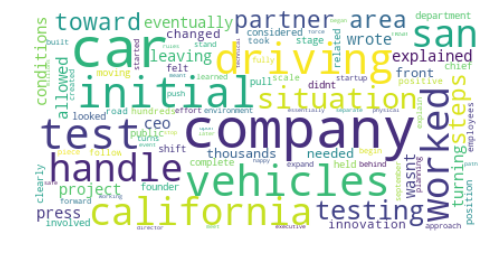

In [25]:
pvtm.create_wordcloud(2)